# Numeryczne rozwiązywanie równań różniczkowych cząstkowych
## Równanie eliptyczne

<br>

## Laboratorium IV
### Metoda Galerkina 2D

In [1]:
%matplotlib notebook

import numpy as np
import pylab
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Użyjemy sympy, by nie musieć samodzielnie liczyć całek.

In [2]:
import sympy as sp
from sympy import symbols, sqrt, exp, diff, integrate, pprint  

x, y = sp.symbols('x y')
                                                                                                                                                              

# pprint(diff(4*x**3+exp(3*x**2*y)+y**2,x))                                                                                                                                          
# pprint(diff(4*x**3+exp(3*x**2*y)+y**2,y))                                                                                                                                          
# pprint(integrate(exp(x*y**2)+sqrt(x)*y**2,x))                                                                                                                                      
# pprint(integrate(exp(x*y**2)+sqrt(x)*y**2,y))

_I = integrate(exp(x*y**2)+sqrt(x)*y**2, (x,0,1), (y,-1,1))
pprint(_I)
print(_I)
print(np.array(_I).astype(np.float64))

-2⋅ℯ + 22/9 + 2⋅√π⋅erfi(1)
-2*E + 22/9 + 2*sqrt(pi)*erfi(1)
2.8584877711550805


Zacznijmy od fukcji bazowych dla metody Galerkina

Proszę zaimplementować funkcja zwracająca funkcje bazowe postaci

$$ sin(i \pi x) sin (j \pi y)$$

In [3]:
def sines(x, y, Nx, Ny):
    ret = []
    for i in range(1, Nx+1):
        for j in range(1, Ny+1):
            ret.append(sp.sin(i*sp.pi*x)*sp.sin(j*sp.pi*y))
    return ret
#  return sp.sin(Nx*sp.pi*x)*sp.sin(Ny*sp.pi*y)

Równanie Poissona:

$$ -\Delta u = f \;\;\; \text{w} \;\;\; \Omega $$
$$ u = 0 \;\;\; \text{na} \;\;\; \partial \Omega $$

Zbudujmy odpowiedni układ równań


$$\sum\limits_{j=1}^{n} c_j \iint_\Omega \nabla \psi_j \nabla \psi_i dxdy = \iint_\Omega f \psi_i dxdy \;\;\; i=1,...,n$$


$$ Ac = b $$

Zaimplementujmy tworzenie takiego układu równań: 

In [4]:
def construct_A_and_b(f, psi, Omega):
    N = len(psi)
    A = sp.zeros(N, N)
    b = sp.zeros(N, 1)
    for i in range(N):
        for j in range(i, N):
            # TODO
            I = integrate(diff(psi[i],x)*diff(psi[j],x) + diff(psi[i],y)*diff(psi[j],y), (x,Omega[0][0],Omega[0][1]), (y,Omega[1][0],Omega[1][1]))
            A[i, j] = A[j, i] = I

        # TODO
        b[i, 0] = integrate(f*psi[i], (x,Omega[0][0],Omega[0][1]), (y,Omega[1][0],Omega[1][1]))
    return A, b

**Implementacja metody różnic skończonych (dla porównania)**

In [5]:
import scipy.sparse.linalg
from typing import Optional
class SetupElliptic:
    def __init__(self, 
                 dx: float, 
                 dy: Optional[float] = None,
                 x_range = (0,1), 
                 y_range = (0,1),
                 f = lambda x, y: 0,
                 boundary_right = lambda y: 0,
                 boundary_up = lambda x: 0,
                 boundary_left = lambda y: 0,
                 boundary_down = lambda x: 0
                ):
        
        dy = dy or dx
        self.x_range = x_range
        self.y_range = y_range
        self.boundary_left = boundary_left
        self.boundary_right = boundary_right
        self.boundary_up = boundary_up
        self.boundary_down = boundary_down        

        self.f = f
        self.x_num = round((self.x_range[1] - self.x_range[0]) / dx) + 1
        self.y_num = round((self.y_range[1] - self.y_range[0]) / dy) + 1
        self.X, self.dx = np.linspace(*self.x_range, self.x_num, retstep=True)
        self.Y, self.dy = np.linspace(*self.y_range, self.y_num, retstep=True)
        
def laplacian_matrix(dx, dy, x_num, y_num):
    size = x_num*y_num
    ones = np.ones(size)
    Ly = scipy.sparse.dia_matrix(([ones, -2*ones, ones], [-1,0,1]), shape=(y_num, y_num))
    My = (1/dy ** 2) * scipy.sparse.block_diag([Ly]*x_num)
    I = np.identity(y_num)
    Mx_data = [ [None]*(x_num) for i in range(x_num)]
    Mx_data[0][0] = -2*I
    for i in range(1, x_num):
        Mx_data[i][i] = -2*I
        Mx_data[i-1][i] = I
        Mx_data[i][i-1] = I
    Mx = (1/dx ** 2) * scipy.sparse.bmat(Mx_data)
    return Mx + My

def scheme_elliptic(setup):
    ret = np.zeros((setup.x_num,setup.y_num))
    ret[0,:] = np.array([setup.boundary_left(setup.Y[j]) for j in range(setup.y_num)])
    ret[-1,:] = np.array([setup.boundary_right(setup.Y[j]) for j in range(setup.y_num)])
    ret[:,0] = np.array([setup.boundary_down(setup.X[i]) for i in range(setup.x_num)])
    ret[:,-1] = np.array([setup.boundary_up(setup.X[i]) for i in range(setup.x_num)])
    
    size = (setup.x_num-2)*(setup.y_num-2)
    r = np.zeros((setup.x_num-2,setup.y_num-2))
    
    r[0,:] = (-1/setup.dy**2)*ret[0,1:-1]
    r[-1,:] = (-1/setup.dy**2)*ret[-1,1:-1]
    r[:,0] = (-1/setup.dx**2)*ret[1:-1,0]
    r[:,-1] = (-1/setup.dx**2)*ret[1:-1,-1]

    f = np.array([[setup.f(setup.X[i], setup.Y[j]) for j in range(1,setup.y_num-1)] for i in range(1,setup.x_num-1)])
    rhs = (r + f).reshape(size, order='C')
    
    # Macierz
    M = laplacian_matrix(setup.dx, setup.dy, setup.x_num-2, setup.y_num-2)
    ret[1:-1,1:-1] = scipy.sparse.linalg.spsolve(M, rhs).reshape(setup.x_num-2, setup.y_num-2)
    return setup.X, setup.Y, ret.T

### Zadanie 1

In [6]:
f = 0
psi = sines(x, y, 2, 2)
Omega = [[0, 1], [0, 1]]
A, b = construct_A_and_b(f, psi, Omega)
pprint(A)
pprint(b)

⎡ 2                  ⎤
⎢π                   ⎥
⎢──   0     0     0  ⎥
⎢2                   ⎥
⎢                    ⎥
⎢       2            ⎥
⎢    5⋅π             ⎥
⎢0   ────   0     0  ⎥
⎢     4              ⎥
⎢                    ⎥
⎢             2      ⎥
⎢          5⋅π       ⎥
⎢0    0    ────   0  ⎥
⎢           4        ⎥
⎢                    ⎥
⎢                   2⎥
⎣0    0     0    2⋅π ⎦
⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


Rozwiązanie symobliczne

In [7]:
c = A.LUsolve(b)
u = 0
for i in range(len(psi)):
    u += c[i, 0] * psi[i]
print(u)

0


Rozwiązanie numeryczne

In [8]:
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)

Pomocnicze funkcje to wyrysowania wyników

In [9]:
def scatter_solution(c, psi, Omega, psi_0=0*x*y, d=32):
    X, Y, u = np.linspace(Omega[0][0], Omega[0][1], d), np.linspace(Omega[1][0], Omega[1][1], d), np.zeros((d, d))
    for i, x_value in enumerate(X):
        for j, y_value in enumerate(Y):
            u[i, j] = psi_0.subs([(x, x_value), (y, y_value)])
            for k in range(len(psi)):
                u[i, j] += float(c[k] * psi[k].subs([(x, x_value), (y, y_value)]))
    return X, Y, u

def scatter_exac(func, Omega, d=32):
    X, Y, u = np.linspace(Omega[0][0], Omega[0][1], d), np.linspace(Omega[1][0], Omega[1][1], d), np.zeros((d, d))
    for i, x_value in enumerate(X):
        for j, y_value in enumerate(Y):
            u[i, j] = func.subs([(x, x_value), (y, y_value)])
    return X, Y, u

In [10]:
def plot_surface(X, Y, u, title = None):
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    
    # Prepare grid.
    X, Y = np.meshgrid(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, u, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-.2, 1.2)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

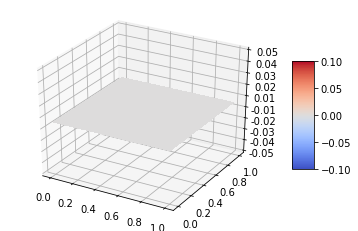

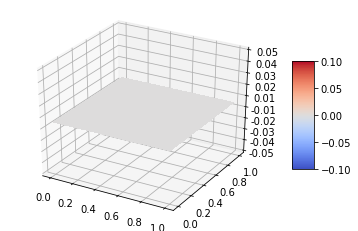

In [11]:
plot_surface(*scatter_solution(c, psi, Omega))
plot_surface(*scatter_exac(0*x*y, Omega))

### Zadanie 2

$$ -\Delta u = - 2  \pi^2  \sin(\pi  x) \sin(\pi y) \;\;\; \text{w} \;\;\; \Omega $$
$$ u = 0 \;\;\; \text{na} \;\;\; \partial \Omega $$

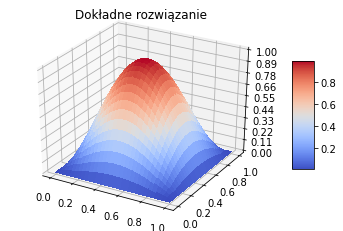

In [12]:
Omega = [[0, 1], [0, 1]]
X,Y,exact = scatter_exac(sp.sin(sp.pi * x) * sp.sin(sp.pi * y), Omega)
plot_surface(X,Y,exact, "Dokładne rozwiązanie")

**Metoda Galerkina**

CPU times: user 3.7 s, sys: 6.98 ms, total: 3.71 s
Wall time: 3.71 s


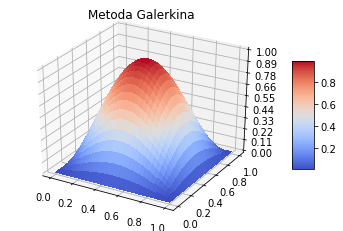

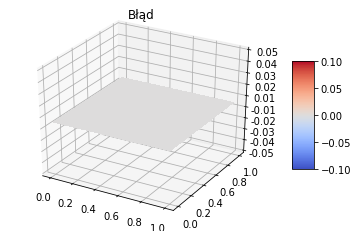

In [13]:
f = 2*(sp.pi ** 2)*sp.sin(sp.pi*x)*sp.sin(sp.pi*y)
psi = sines(x, y, 2, 2)

A, b = construct_A_and_b(f, psi, Omega)
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)
%time X,Y,galerkin = scatter_solution(c, psi, Omega)
plot_surface(X,Y, galerkin, "Metoda Galerkina")
plot_surface(X,Y, exact-galerkin, "Błąd")

**Metoda różnic skończonych**

CPU times: user 9.63 ms, sys: 20 µs, total: 9.65 ms
Wall time: 11.4 ms


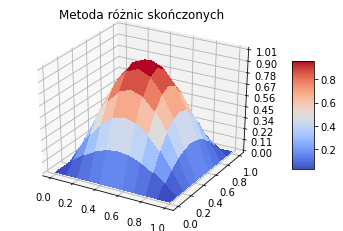

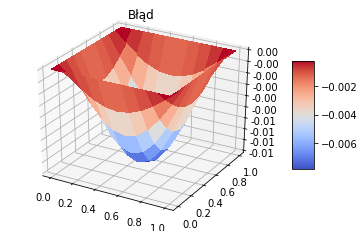

In [14]:
setup = SetupElliptic(
    dx=0.1, dy=0.1,
    x_range=(0.0, 1.0), y_range=(0.0, 1.0),
    f=lambda x,y: (-2)*(np.pi ** 2)*np.sin(np.pi*x)*np.sin(np.pi*y),
    boundary_right = lambda y: 0.0,
    boundary_up = lambda x: 0.0,
    boundary_left = lambda y: 0.0,
    boundary_down = lambda x: 0.0
)
%time X,Y,finite_difference = scheme_elliptic(setup)
m_X, m_Y = np.meshgrid(X,Y)
exact = np.sin(np.pi * m_X) * np.sin(np.pi * m_Y)
plot_surface(X,Y,finite_difference, "Metoda różnic skończonych")
plot_surface(X,Y,exact-finite_difference, "Błąd")

### Zadanie 3
Rozważmy zagadnienie z niezerowym brzegiem:
$$ -\Delta u = 0 $$
$$ \Omega = (0, a) \text{x} (0, a) $$

$$ u(0, y) = 0 $$
$$ u(a, y) = u_0(e^y - 1) $$
$$ u(x, 0) = 0 $$
$$ u(x, a) = u_0(e^x - 1) $$

Będziemy szukać funkcji postaci:

$$ u_{i}(x, y) = \psi_0 (x, y) + \sum\limits_{j=1}^{n} c_j \psi_j (x, y) $$

Proponuję:

$$ \psi_0 (x, y) = u_0 \frac{(e^x - 1)(e^y - 1)}{e^a - 1} $$


Rozwiąż dla $a = 3$

In [15]:
def construct_A_and_b_with_psi_0(f, psi, psi_0, Omega):
    N = len(psi)
    A = sp.zeros(N, N)
    b = sp.zeros(N, 1)
    f_minus_Lpsi_0 = f + (diff(psi_0,x,x) + diff(psi_0,y,y))
    for i in range(N):
        for j in range(i, N):
            # TODO
            I = integrate(-(diff(psi[i],x,x)+diff(psi[i],y,y))*psi[j], (x,Omega[0]), (y,Omega[1]))
            A[i, j] = A[j, i] = I

        # TODO
        #b[i, 0] = integrate(f*psi[i], (x,Omega[0][0],Omega[0][1]), (y,Omega[1][0],Omega[1][1]))
        b[i, 0] = integrate(f_minus_Lpsi_0*psi[i], (x,Omega[0]), (y,Omega[1]))
    return A, b
    pass  # TODO

In [16]:
f = 0
psi = sines(x, y, 1, 1)
a = 3
Omega = [[0, a], [0, a]]
u0 = 1
psi_0 = (u0/(sp.exp(a)-1))*(sp.exp(x)-1)*(sp.exp(y)-1)
A, b = construct_A_and_b_with_psi_0(f, psi, psi_0, Omega)

Rozwiązanie symboliczne jest dość skomplikowane

In [17]:
c = A.LUsolve(b)
u = psi_0
for i in range(len(psi)):
    u += c[i, 0] * psi[i]
print(u)
# pprint(u)

(exp(x) - 1)*(exp(y) - 1)/(-1 + exp(3)) + 2*(-4*pi*exp(3)/(-pi**5 - 2*pi**3 - pi + pi*exp(3) + 2*pi**3*exp(3) + pi**5*exp(3)) - 2*pi**3/(-pi**5 - 2*pi**3 - pi + pi*exp(3) + 2*pi**3*exp(3) + pi**5*exp(3)) - 4*pi/(-pi**5 - 2*pi**3 - pi + pi*exp(3) + 2*pi**3*exp(3) + pi**5*exp(3)) + 2*pi**3*exp(6)/(-pi**5 - 2*pi**3 - pi + pi*exp(3) + 2*pi**3*exp(3) + pi**5*exp(3)))*sin(pi*x)*sin(pi*y)/(9*pi**2)


In [18]:
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)

**Metoda Galerkina:**

CPU times: user 2.56 s, sys: 17.1 ms, total: 2.58 s
Wall time: 2.57 s


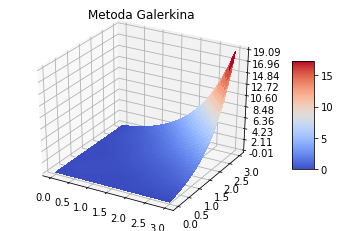

In [19]:
%time X,Y,galerkin = scatter_solution(c, psi, Omega, psi_0)
plot_surface(X,Y,galerkin,"Metoda Galerkina")

**Metoda różnic skończonych:**

CPU times: user 2.79 s, sys: 1.08 s, total: 3.87 s
Wall time: 2.91 s


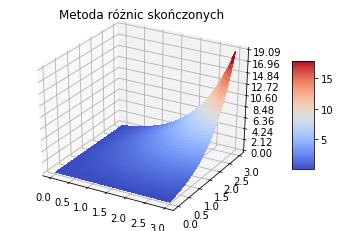

In [20]:
setup = SetupElliptic(dx=0.01, dy=0.01,
    x_range=(0.0, a), y_range=(0.0, a),
    f = lambda x,y: 0.0,
    boundary_right = lambda y: u0*(np.exp(y)-1), # boundary right
    boundary_up = lambda x: u0*(np.exp(x)-1), # boundary up
    boundary_left = lambda y: 0.0, # boundary left
    boundary_down = lambda x: 0.0  # boundary down
)
%time X,Y,finite_difference = scheme_elliptic(setup)
plot_surface(X,Y,finite_difference, "Metoda różnic skończonych")

### Zadanie 4

$$ -\Delta u = \sin(\pi y) (4 \pi x \cos(\pi  x) -
    (\pi^2 (x^2 + y^2)-2) \sin(\pi x)) + 
    \sin(\pi  x) (4 \pi y \cos(\pi y) -
    (\pi^2  (x^2 + y^2) - 2)  \sin(\pi y)) \;\;\; \text{w} \;\;\; \Omega $$
$$ u = 0 \;\;\; \text{na} \;\;\; \partial \Omega $$

Srawdź błąd względny metody, co należy zmienić, aby się zmiejszył?

**Dokładne rozwiązanie:**

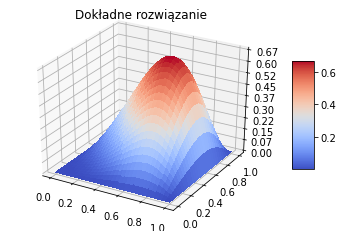

In [21]:
Omega = [[0, 1], [0, 1]]
X, Y, u_exact = scatter_exac(sp.sin(sp.pi * x) * sp.sin(sp.pi * y) * (x**2 + y**2), Omega)
plot_surface(X, Y, u_exact, "Dokładne rozwiązanie")

**Metoda Galerkina:**

In [22]:
f = sp.sin(sp.pi * y) * (4 * sp.pi * x *sp.cos(sp.pi * x) -\
    (sp.pi**2 * (x**2 + y**2) - 2) * sp.sin(sp.pi * x)) + \
    sp.sin(sp.pi * x) * (4 * sp.pi * y *sp.cos(sp.pi * y) -\
    (sp.pi**2 * (x**2 + y**2) - 2) * sp.sin(sp.pi * y))
psi = sines(x, y, 2, 2)
A, b = construct_A_and_b(-f, psi, Omega)

In [23]:
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)

In [24]:
def scatter_solution(c, psi, Omega, psi_0=0*x*y, d=32):
    X, Y, u = np.linspace(Omega[0][0], Omega[0][1], d), np.linspace(Omega[1][0], Omega[1][1], d), np.zeros((d, d))
    for i, x_value in enumerate(X):
        for j, y_value in enumerate(Y):
            u[i, j] = psi_0.subs([(x, x_value), (y, y_value)])
            for k in range(len(psi)):
                u[i, j] += float(c[k] * psi[k].subs([(x, x_value), (y, y_value)]))
    return X, Y, u

def scatter_exac(func, Omega, d=32):
    X, Y, u = np.linspace(Omega[0][0], Omega[0][1], d), np.linspace(Omega[1][0], Omega[1][1], d), np.zeros((d, d))
    for i, x_value in enumerate(X):
        for j, y_value in enumerate(Y):
            u[i, j] = func.subs([(x, x_value), (y, y_value)])
    return X, Y, u

CPU times: user 4.81 s, sys: 23.9 ms, total: 4.83 s
Wall time: 4.84 s


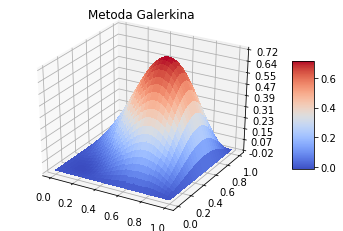

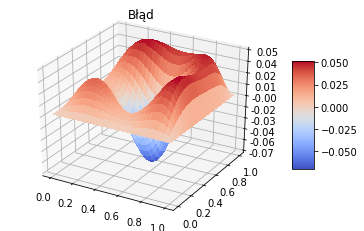

In [25]:
%time X, Y, u_numeric = scatter_solution(c, psi, Omega)
plot_surface(X, Y, u_numeric, "Metoda Galerkina")
plot_surface(X, Y, u_exact-u_numeric, "Błąd")

**Metoda różnic skończonych:**

CPU times: user 300 ms, sys: 19 ms, total: 319 ms
Wall time: 299 ms


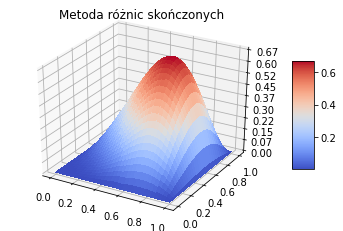

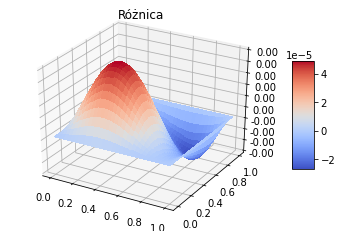

In [26]:
setup = SetupElliptic(dx=0.01, dy=0.01,
    x_range=(0.0, 1.0), y_range=(0.0, 1.0),
    f=lambda x,y: -(-(np.sin(np.pi * y) * (4 * np.pi * x *np.cos(np.pi * x) -\
        (np.pi**2 * (x**2 + y**2) - 2) * np.sin(np.pi * x)) + \
        np.sin(np.pi * x) * (4 * np.pi * y *np.cos(np.pi * y) -\
        (np.pi**2 * (x**2 + y**2) - 2) * np.sin(np.pi * y)))),
    boundary_right=lambda y: 0.0, # boundary right
    boundary_up=lambda x: 0.0, # boundary up
    boundary_left=lambda y: 0.0, # boundary left
    boundary_down=lambda x: 0.0  # boundary down
)
%time X,Y,finite_difference = scheme_elliptic(setup)
plot_surface(X,Y,finite_difference, "Metoda różnic skończonych")
m_X, m_Y = np.meshgrid(X,Y)
exact = np.sin(np.pi * m_X) * np.sin(np.pi * m_Y) * (m_X**2 + m_Y**2)

plot_surface(X,Y,exact-finite_difference, "Różnica")

### Zadanie 5

$$ -\Delta u = 2 (x^2 + y^2) - 2 \pi ^ 2 \sin(\pi x) \sin(\pi y) \;\;\; \text{w} \;\;\; \Omega $$
$$ \Omega = (0, a) \text{x} (0, a) $$

$$ u(0, y) = 0 $$
$$ u(a, y) = y^2 $$
$$ u(x, 0) = 0 $$
$$ u(x, a) = x^2 $$

**Dokładne rozwiązanie:**

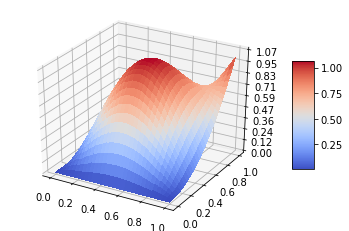

In [27]:
a = 1
Omega = [[0, a], [0, a]]
X, Y, u_exact = scatter_exac(x**2 * y**2 + sp.sin(sp.pi * x) * sp.sin(sp.pi * y), Omega)
plot_surface(X, Y, u_exact)

**Metoda Galerkina:**

In [28]:
f = -(2*(x**2 + y**2)-2*(sp.pi**2)*sp.sin(sp.pi*x)*sp.sin(sp.pi*y))
psi = sines(x, y, 2, 2)

psi_0 =  (x*y/a)**2

A, b = construct_A_and_b_with_psi_0(f, psi, psi_0, Omega)

In [29]:
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)

CPU times: user 4.3 s, sys: 31 ms, total: 4.33 s
Wall time: 4.33 s


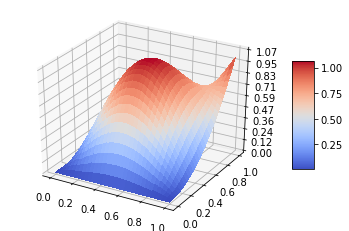

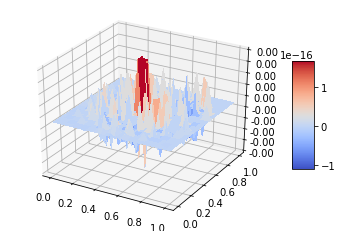

In [30]:
%time X, Y, u_numeric = scatter_solution(c, psi, Omega, psi_0)
plot_surface(X, Y, u_numeric)
plot_surface(X, Y, u_exact-u_numeric)

**Metoda różnic skończonych:**

CPU times: user 1.08 s, sys: 290 ms, total: 1.38 s
Wall time: 1.11 s


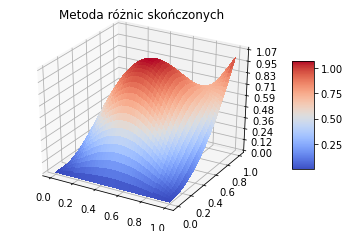

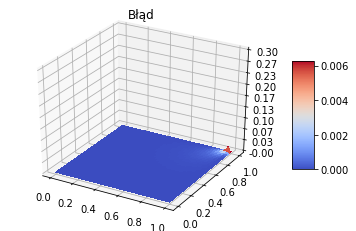

In [31]:
setup = SetupElliptic(dx=0.005, dy=0.005,
    f=lambda x,y: (2*(x**2 + y**2)-2*(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)),
    x_range=(0.0, a), y_range=(0.0, a),
    boundary_right=lambda y: y**2, # boundary right
    boundary_up=lambda x: x**2, # boundary up
    boundary_left=lambda y: 0.0, # boundary left
    boundary_down=lambda x: 0.0  # boundary down
)
%time X,Y,finite_difference = scheme_elliptic(setup)
plot_surface(X,Y,finite_difference, "Metoda różnic skończonych")
m_X, m_Y = np.meshgrid(X,Y)
exact = m_X**2 * m_Y**2 + np.sin(np.pi * m_X) * np.sin(np.pi * m_Y)
plot_surface(X,Y,exact-finite_difference, "Błąd")

### Zadanie 6*: 
$ -\Delta u = -3 \pi^2 \sin(\pi x) \sin(\pi y) \sin(\pi z)$


$ u = 0 \;\;\; \text{na} \;\;\; \partial \Omega $


$ \Omega = (0, 1) \text{x} (0, 1) \text{x} (0, 1)$

Rozwiązadnie dokładne:
$\sin(\pi x) \sin(\pi y) \sin(\pi z)$

In [32]:
def sines_3d(x, y, z, Nx, Ny, Nz):
    ret = []
    for i in range(1, Nx+1):
        for j in range(1, Ny+1):
            for k in range(1, Nz+1):
                ret.append(sp.sin(i*sp.pi*x)*sp.sin(j*sp.pi*y)*sp.sin(k*sp.pi*z))
    return ret

In [33]:
x, y, z = sp.symbols('x y z')

In [34]:
def construct_A_and_b_3d(f, psi, Omega):
    N = len(psi)
    A = sp.zeros(N, N)
    b = sp.zeros(N, 1)
    for i in range(N):
        for j in range(i, N):
            # TODO
            I = integrate(diff(psi[i],x)*diff(psi[j],x) + diff(psi[i],y)*diff(psi[j],y) + diff(psi[i],z)*diff(psi[j],z), (x,Omega[0][0],Omega[0][1]), (y,Omega[1][0],Omega[1][1]), (z,Omega[2][0],Omega[2][1]))
            A[i, j] = A[j, i] = I

        # TODO
        b[i, 0] = integrate(f*psi[i], (x,Omega[0][0],Omega[0][1]), (y,Omega[1][0],Omega[1][1]), (z,Omega[2][0],Omega[2][1]))
    return A, b

In [35]:
def scatter_solution_3d(c, psi, Omega, psi_0=0*x*y, d=24):
    X, Y, Z, u = np.linspace(Omega[0][0], Omega[0][1], d), np.linspace(Omega[1][0], Omega[1][1], d), np.linspace(Omega[2][0], Omega[2][1], d), np.zeros((d, d, d))
    for i, x_value in enumerate(X):
        for j, y_value in enumerate(Y):
            for k, z_value in enumerate(Z):
                u[i, j, k] = psi_0.subs([(x, x_value), (y, y_value), (z, z_value)])
                for l in range(len(psi)):
                    u[i, j, k] += float(c[l] * psi[l].subs([(x, x_value), (y, y_value), (z, z_value)]))
    return X, Y, Z, u



In [36]:

f = 3*(sp.pi ** 2)*sp.sin(sp.pi*x)*sp.sin(sp.pi*y)*sp.sin(sp.pi*z)
psi = sines_3d(x, y, z, 1, 1, 1)
Omega = [[0, 1], [0, 1], [0, 1]]
A, b = construct_A_and_b_3d(f, psi, Omega)
A = np.array(A).astype(np.float64)
b = np.array(b).astype(np.float64)
c = np.linalg.solve(A, b)

u = 0
for i in range(len(psi)):
    u += c[i, 0] * psi[i]
print("u=", u)

X,Y,Z,zarray = scatter_solution_3d(c, psi, Omega)

u= 1.0*sin(pi*x)*sin(pi*y)*sin(pi*z)


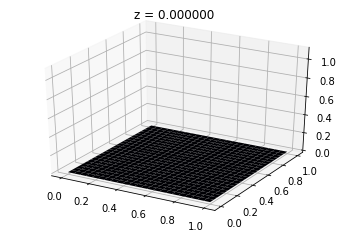

In [37]:
import matplotlib.animation as animation
from IPython.display import HTML

fps = 10 # frame per sec
frn = 24 # frame number of the animation
m_X, m_Y = np.meshgrid(X,Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
txt_title = ax.set_title('')
plot = [ax.plot_surface(m_X, m_Y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.1)

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(m_X, m_Y, zarray[:,:,frame_number], cmap="magma")
    txt_title.set_text('z = {:f}'.format(Z[frame_number]))

anim = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

In [38]:
from IPython.display import HTML
HTML(anim.to_html5_video())